In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns
theano.config.compute_test_value = 'ignore'


from scipy.integrate import odeint
SEED=2021

import jax
from jax.experimental.ode import odeint as jodeint
import jax.numpy as jnp


from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
# Simple enzymatic reaction with two species
def rhs(y, t, p):
    S, P = y[0], y[1]
    vmax, K_S = p[0], p[1]
    dPdt = vmax * (S / K_S + S)
    dSdt = -dPdt
    return [
        dSdt,
        dPdt,
    ]

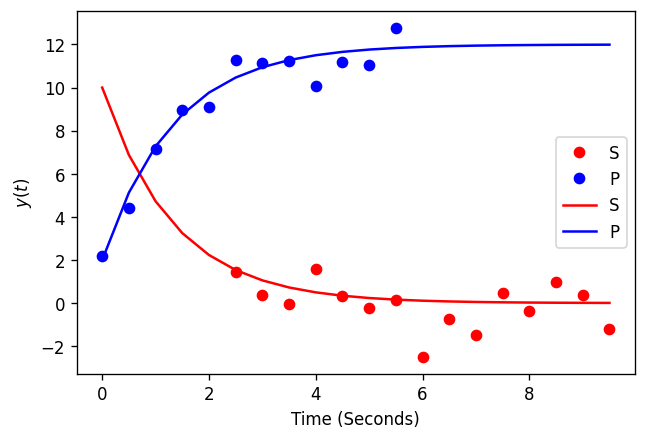

In [3]:
rng=np.random.default_rng(SEED)

# Times for observation
times = np.arange(0, 10, 0.5)
S_idx = np.arange(5, len(times))
P_idx = np.arange(12)
S_t = times[S_idx]
P_t = times[P_idx]

y0_true = (10., 2.)
theta_true = vmax, K_S = (0.5, 2.)
sigma = 1

obs = odeint(rhs, t=times, y0=y0_true, args=(theta_true,))
S_obs = rng.normal(obs[S_idx, 0], sigma)
P_obs = rng.normal(obs[P_idx, 1], sigma)

fig, ax = plt.subplots(dpi=120)
plt.plot(S_t, S_obs, label="S", linestyle="none", marker="o", color="red")
plt.plot(P_t, P_obs, label="P", linestyle="none", marker="o", color="blue")
plt.plot(times, obs.T[0], label="S", color="red")
plt.plot(times, obs.T[1], label="P", color="blue")
plt.legend()
plt.xlabel("Time (Seconds)")
plt.ylabel(r"$y(t)$")
plt.show()

In [4]:
class ODEop(tt.Op):
        
    def __init__(self, solver, vectorized=True):
        # JAX's vmap is all you need to vectorize the solver to work off of a list of parameter values
        self._solver = solver if not vectorized else jax.jit(jax.vmap(solver))
        # JAX's autodifferentiation allows automatic construction of the vector-Jacobian product
        self._vjp = jax.jit(lambda params,grad: jax.vjp(self._solver,params)[1](grad)[0])
        # We need a separate op to allow Theano to calculate the gradient via JAX's vjp
        self._grad_op = ODEGradop(self._vjp)
        
    def make_node(self, p):
        # Tells Theano what to expect in terms of the shape/number of inputs and outputs
        p = theano.tensor.as_tensor_variable(p)
        node = theano.tensor.Apply(self, [p], [p.type()])
        return node

    def perform(self, node, inputs, output):
        # Just calls the solver on the parameters
        params = inputs[0]
        output[0][0] = np.array(self._solver(params))  # get the numerical solution of ODE states

    def grad(self, inputs, output):
        # Theano's gradient calculation
        params = inputs[0]
        grads = output[0] 
        return [self._grad_op(params, grads)]
    
class ODEGradop(tt.Op):
    
    def __init__(self, vjp):
        self._vjp = vjp
        
    def make_node(self, p, g):
        p = theano.tensor.as_tensor_variable(p)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.tensor.Apply(self, [p, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        params = inputs_storage[0]
        grads = inputs_storage[1]
        out = output_storage[0]
        # Get the numerical vector-Jacobian product
        out[0] = np.array(self._vjp(params,grads))

In [5]:
class ODE:
    def __init__(self, solver, times, vectorized=True):
        self._times = times
        self._vectorized = vectorized
        self.__solver = solver
        self.build_solvers()
        self.build_op()
    
    def solve(self,params):
        params = np.atleast_2d(params)
        M,N = params.shape
        return self._solver(params) if params.shape[0]==1 else self._vsolver(params)
    
    def build_solvers(self):
        self._solver = jax.jit(lambda params: self.__solver(self._times,params))
        self._vsolver = jax.jit(jax.vmap(self._solver))
    
    def build_op(self):
        self.Op = ODEop(self._solver, vectorized=self.vectorized)
        
    def sample_posterior_fits(self, fit, param_names, n=1000):
        params_array = np.array([fit[p][:n] for p in param_names]).T
        if self.vectorized:
            solutions = jax.vmap(self._vsolver)(params_array)
            return np.array(solutions).reshape([params_array.shape[0], n, 2, -1])
        else:
            solutions = self._vsolver(params_array)
            return np.array(solutions).reshape([n, 2, -1])
        
    @property
    def vectorized(self):
        return self._vectorized
    
    @vectorized.setter
    def vectorized(self, is_vec: bool):
        self._vectorized = is_vec
        self.build_op()
        
    @property
    def times(self):
        return self._times
    
    @vectorized.setter
    def times(self, _times):
        self._times = _times
        self.build_solvers()
        self.build_op()

# Model definition

## Native PyMC3 implementation

In [12]:
with pm.Model() as p_model:
    sigma = pm.Exponential("sigma", 1)
    vmax = pm.Lognormal("vmax", 0, 1)
    K_S = pm.Lognormal("K_S", 0, 1)
    s0 = pm.Lognormal("s_0", mu=np.log(10), sd=1)
    
    kin_model = pm.ode.DifferentialEquation(
        func=rhs,
        times=times,
        n_states=len(y0_true),
        n_theta=len(theta_true)
    )

    solution = kin_model(
        y0=[s0, y0_true[1]],
        theta=[vmax, K_S],
        return_sens=False
    )

    S_hat = solution.T[0][S_idx]
    P_hat = solution.T[1][P_idx]

    S_lik = pm.Normal("S_lik", mu=S_hat, sd=sigma, observed=S_obs)
    P_lik = pm.Normal("P_lik", mu=P_hat, sd=sigma, observed=P_obs)
    
    trace = pm.sample(1500)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s_0, K_S, vmax, sigma]
INFO:pymc3:NUTS: [s_0, K_S, vmax, sigma]


ValueError: Not enough samples to build a trace.

Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/usr/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.9/multiprocessing/queues.py", li

## Jax Op

In [6]:
def get_sol(times, params):
    s0, vmax, K_S = params
    p0 = y0_true[1]
    solution = jodeint(rhs, (s0, p0), times, (vmax, K_S))
    return jnp.hstack(solution)

reaction_Op = ODEop(get_sol)

# Or, equivalently, with the helper class
reaction = ODE(get_sol, times, vectorized=False)
reaction_Op = reaction.Op

with pm.Model() as j_model:
    sigma = pm.Exponential("sigma", 1)
    vmax = pm.Lognormal("vmax", 0, 1)
    K_S = pm.Lognormal("K_S", 0, 1)
    s0 = pm.Lognormal("s_0", mu=np.log(10), sd=1)
    #p0 = pm.Normal("blue_0", mu=10, sd=2)
       
    params = tt.stack([s0, vmax, K_S])
    solution = reaction.Op(params).reshape([2, -1])
    
    S_hat = solution[0,:][S_idx]
    P_hat = solution[1,:][P_idx]

    S_lik = pm.Normal("S_lik", mu=S_hat, sd=sigma, observed=S_obs)
    P_lik = pm.Normal("P_lik", mu=P_hat, sd=sigma, observed=P_obs)
    
    trace = pm.sample_smc(1500, parallel=True)

Initializing SMC sampler...
INFO:pymc3:Initializing SMC sampler...
Sampling 2 chains in 2 jobs
INFO:pymc3:Sampling 2 chains in 2 jobs


TypeError: cannot pickle 'jaxlib.xla_extension.jax_jit.CompiledFunction' object

In [7]:
trace["K_S"]

array([2.30155476, 2.59044871, 1.58400315, ..., 2.21788822, 0.71362068,
       1.64607317])

In [8]:
trace.varnames

['sigma_log__',
 'vmax_log__',
 'K_S_log__',
 's_0_log__',
 'sigma',
 'vmax',
 'K_S',
 's_0']

In [9]:
calibration_variable_names = [
    "sigma",
    "vmax",
    "K_S",
    "s_0",
]

/home/volps/pdeco/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/volps/pdeco/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/volps/pdeco/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  w

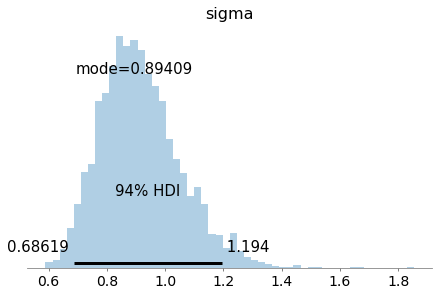

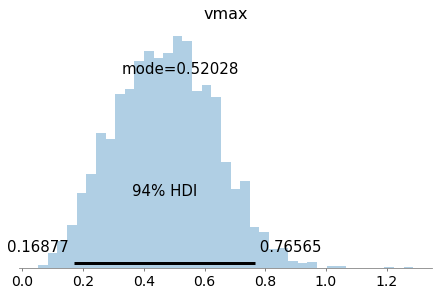

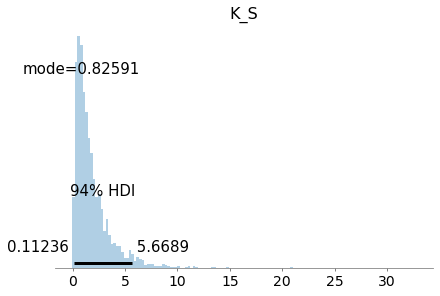

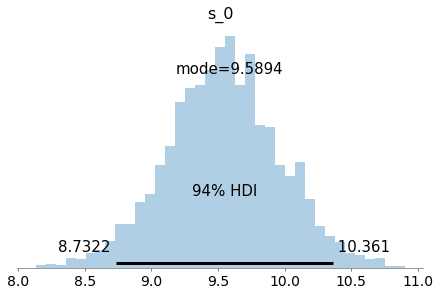

In [10]:
plot_step = 1
# progress_bar = tqdm(calibration_variable_names)
for variable in calibration_variable_names:
    pm.plot_posterior(
        trace[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=5,
        point_estimate="mode"
    )

plt.show()

In [25]:
percentile_cut = 2.5

S_min = np.percentile(trace["S_lik"], percentile_cut, axis=0)
S_max = np.percentile(trace["S_lik"], 100 - percentile_cut, axis=0)
S_fit = np.percentile(trace["S_lik"], 50, axis=0)

KeyError: 'Unknown variable S_lik'